In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os
import copy
import torch.nn as nn

# Visualize

In [32]:
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, image3, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].set_title(titles[0])
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].set_title(titles[1])
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[2].set_title(titles[2])
    axes[2].imshow(image3)
    axes[2].axis('off')
    


    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        plt.savefig(filename, bbox_inches='tight')


    plt.show()

In [33]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()


# ResNet 

# Non-Quantized detector


In [44]:
detector = 'Regular'
c_base=0.1
d_base=0.0
c_integrated=0.2
d_integrated=2.0

base_path = f"/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f"
images_cw_base = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"
images_cw_rbf = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
images_benign = f"Benign_Datasets/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"

predictions_integrated = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
predictions_base = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"

predictions_benign_rbf = f"Predictions/RBF/CW_type-benign_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_base_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_integrated_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_rbf_c-{c_integrated}_d-{d_integrated}.pickle"

filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pt"
filtered_indices_integrated = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pt" 

images_cw_base = os.path.join(base_path, images_cw_base)
images_cw_rbf = os.path.join(base_path, images_cw_rbf)
images_benign = os.path.join(base_path, images_benign)
predictions_base_path = os.path.join(base_path, predictions_base)
predictions_integrated_path = os.path.join(base_path, predictions_integrated)

predictions_benign_rbf_path = os.path.join(base_path, predictions_benign_rbf)
predictions_base_rbf_path = os.path.join(base_path, predictions_base_rbf)
predictions_integrated_rbf_path = os.path.join(base_path, predictions_integrated_rbf)


filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)
filtered_indices_integrated_path = os.path.join(base_path, filtered_indices_integrated)




In [45]:
# Filter by common indices
filtered_indices_base = torch.load(filtered_indices_base_path)
filtered_indices_integrated = torch.load(filtered_indices_integrated_path)


filtered_indices_base = [x.item() for x in filtered_indices_base]
filtered_indices_integrated = [x.item() for x in filtered_indices_integrated]
base_indices = set(filtered_indices_base)
integrated_indices = set(filtered_indices_integrated)
common_indices = list(base_indices.intersection(integrated_indices))


with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)
    images_cw_base[0] = images_cw_base[0][common_indices]
    images_cw_base[1] = images_cw_base[1][common_indices]
    

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)
    images_cw_rbf[0] = images_cw_rbf[0][common_indices]
    images_cw_rbf[1] = images_cw_rbf[1][common_indices]


with open(images_benign, 'rb') as in_file:
    images_benign = pickle.load(in_file)
    images_benign[0] = images_benign[0][common_indices]
    images_benign[1] = images_benign[1][common_indices]

with open(predictions_base_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_integrated_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_benign_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_benign_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_base_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_integrated_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])[common_indices]





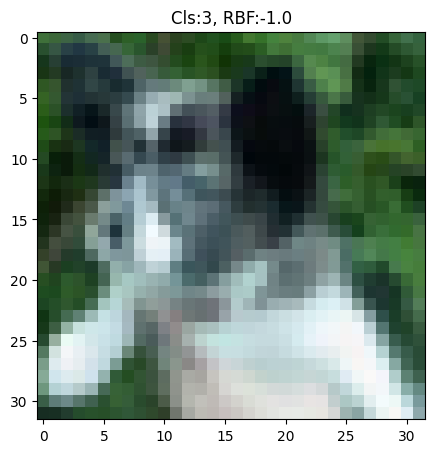

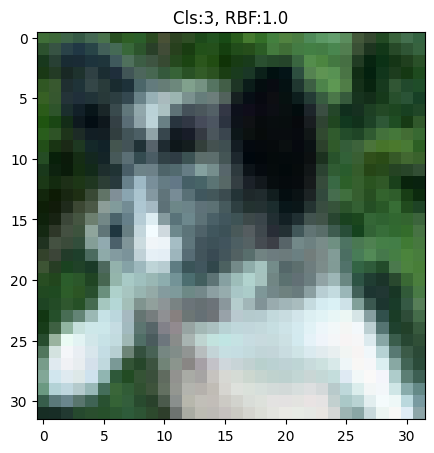

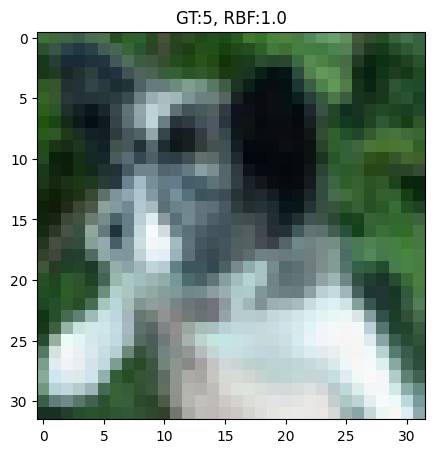

In [46]:
idx = 78
title = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
imshow(images_cw_base[0][idx], title=title)
title = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
imshow(images_cw_rbf[0][idx], title=title)
title = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
imshow(images_benign[0][idx], title=title)

# Compute pixel-wise metrics


In [47]:
MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [48]:
l2_loss_base_per_sample = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base_per_sample = l2_loss_base_per_sample.sum(dim=1).mean()

l2_loss_integrated_per_sample = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_integrated_per_sample = l2_loss_integrated_per_sample.sum(dim=1).mean()
print(f"L2 Ball : Base {l2_loss_base_per_sample}, Integrated : {l2_loss_integrated_per_sample}")

L2 Ball : Base 0.027949325740337372, Integrated : 0.09481242299079895


In [49]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
print(f"Mean Per pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Mean Per pixel : Base 9.098087502934504e-06, Integrated : 3.0863418942317367e-05


In [50]:
l2_loss_base = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean().item()

l2_loss_rbf = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
l2_loss_rbf = l2_loss_rbf.mean().item()
#print("Mean max pixel differene between CW RBF and benign is : ", l2_loss_rbf.item())
#print("Mean max pixel differene between CW base and benign is : ", l2_loss_base.item())
print(f"Max pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Max pixel : Base 0.0003694186743814498, Integrated : 0.000588989641983062


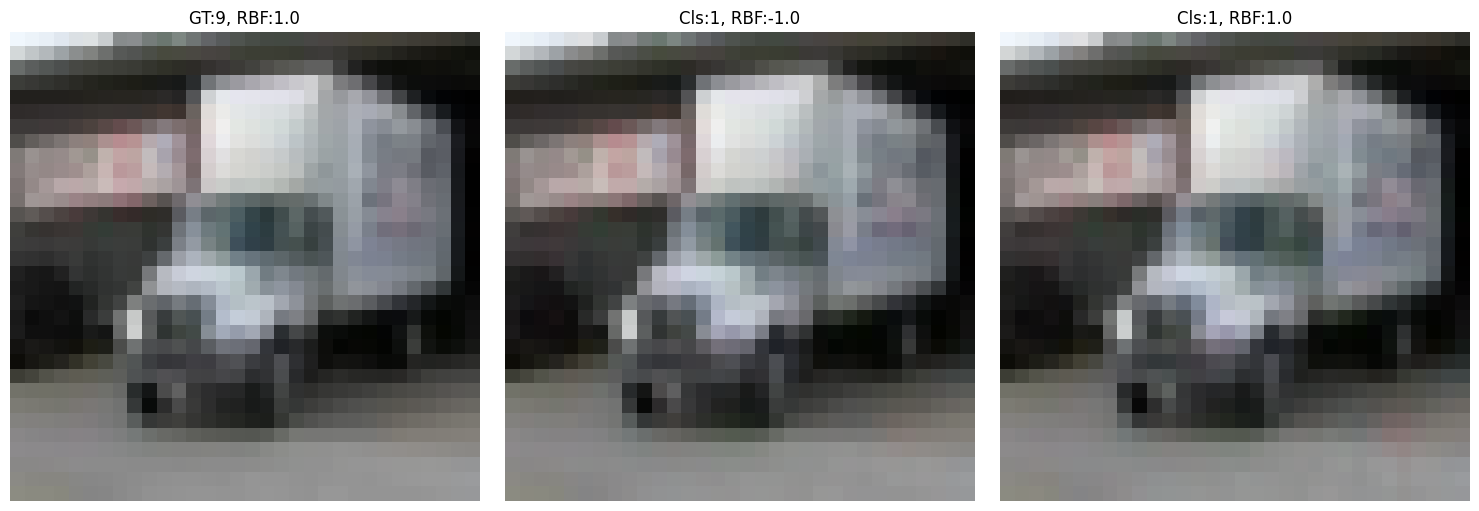

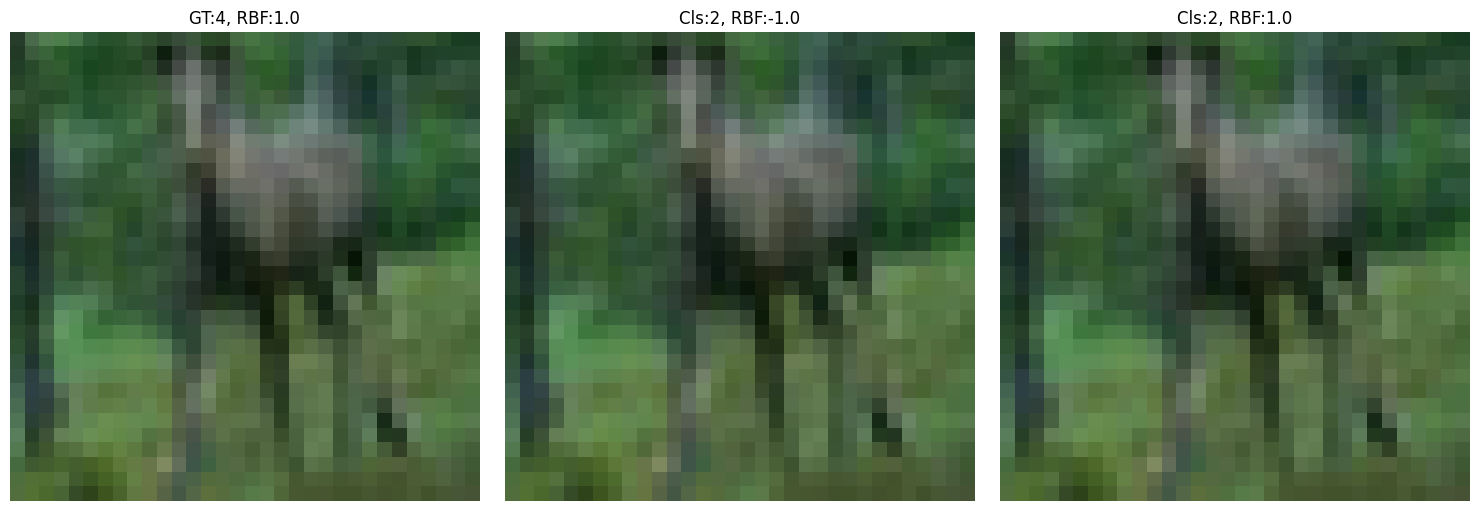

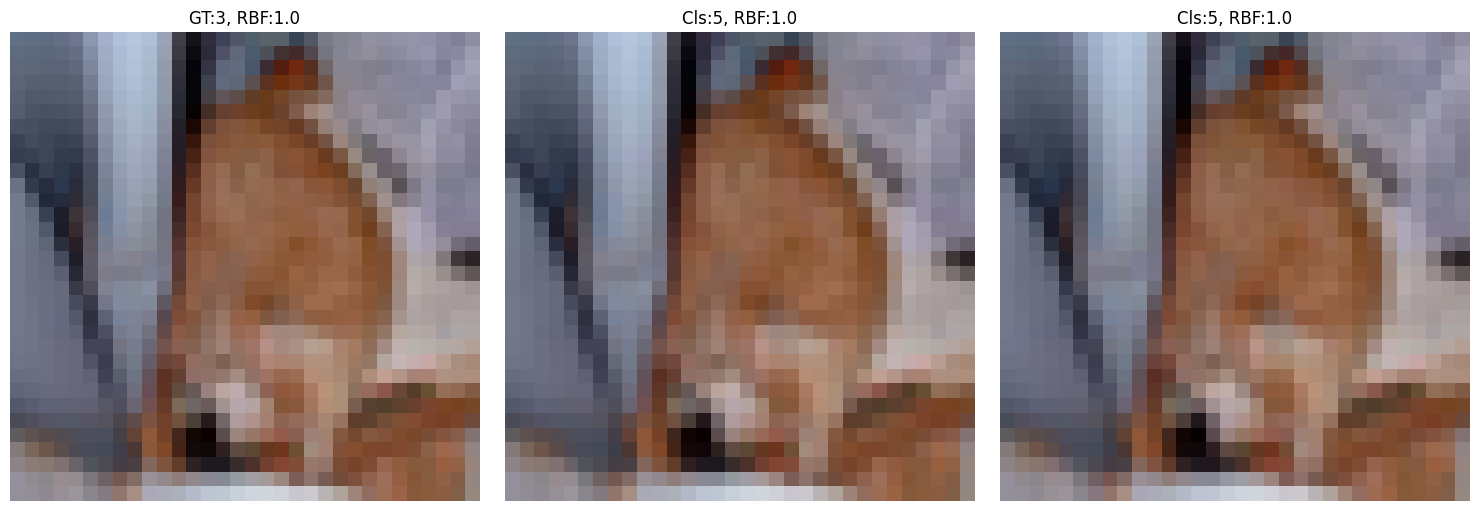

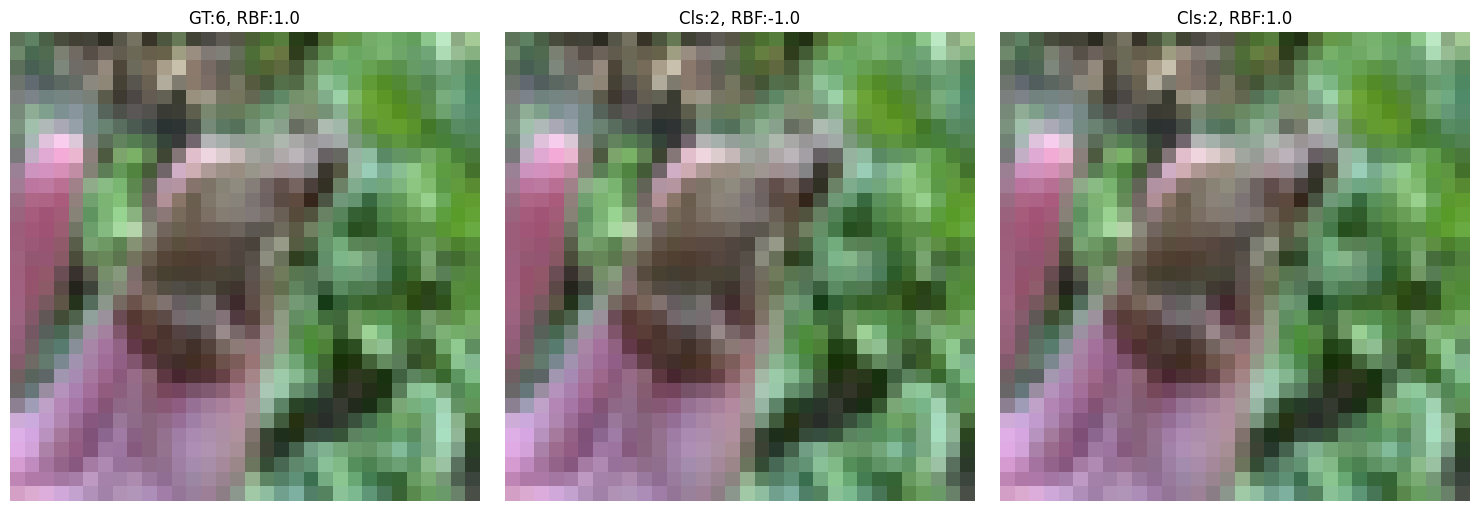

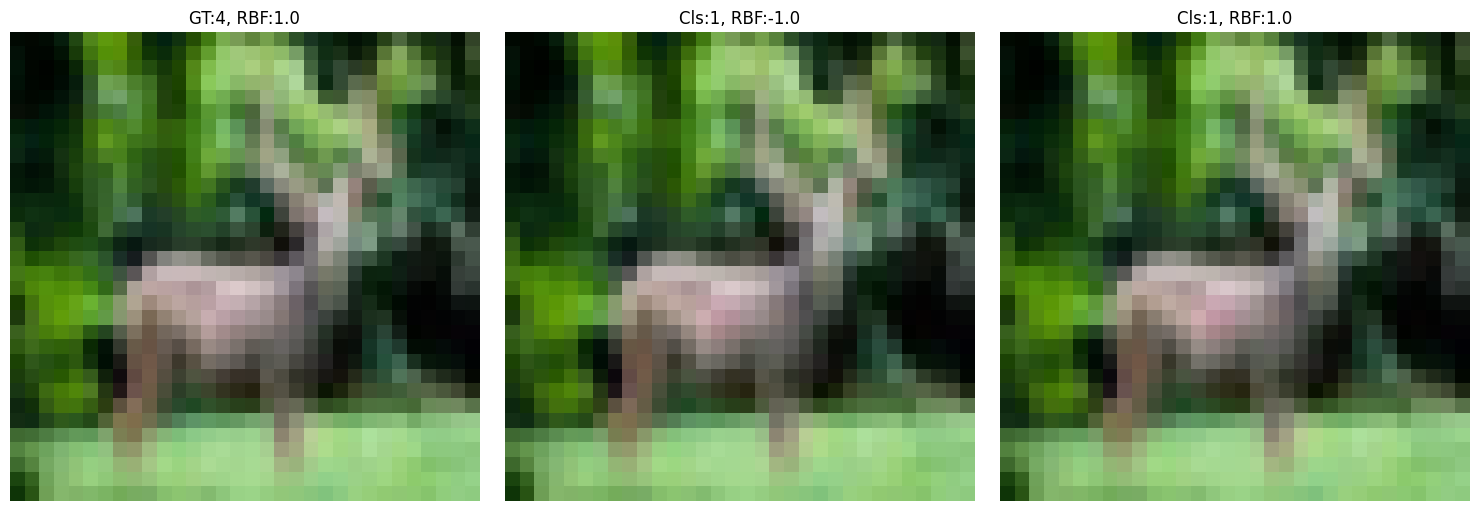

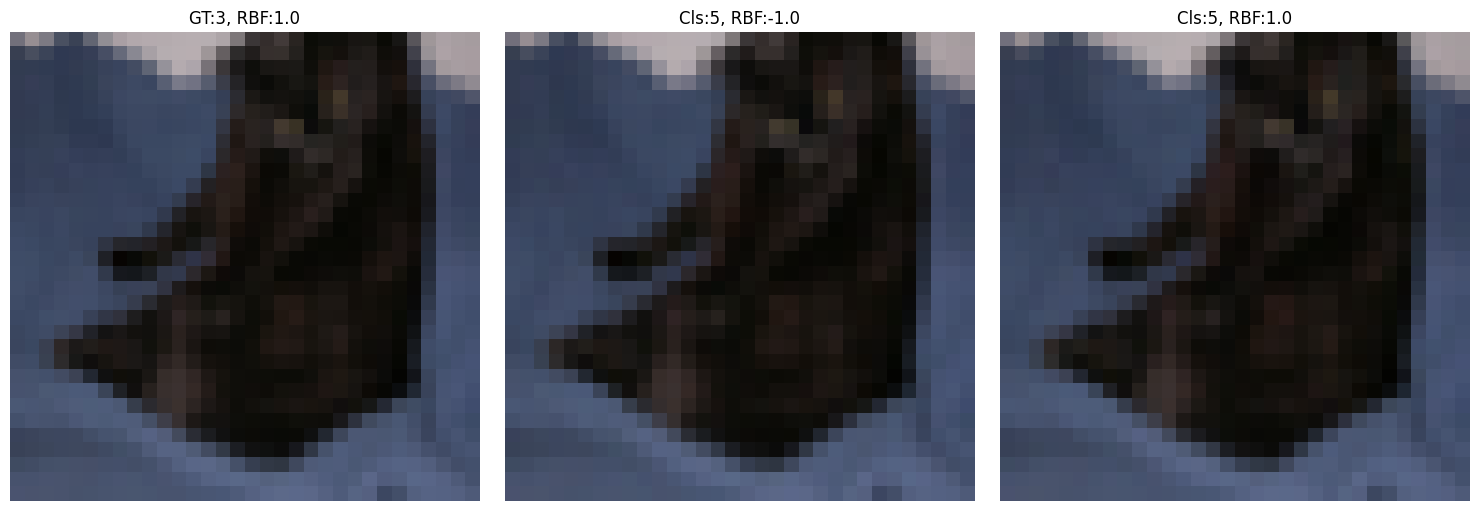

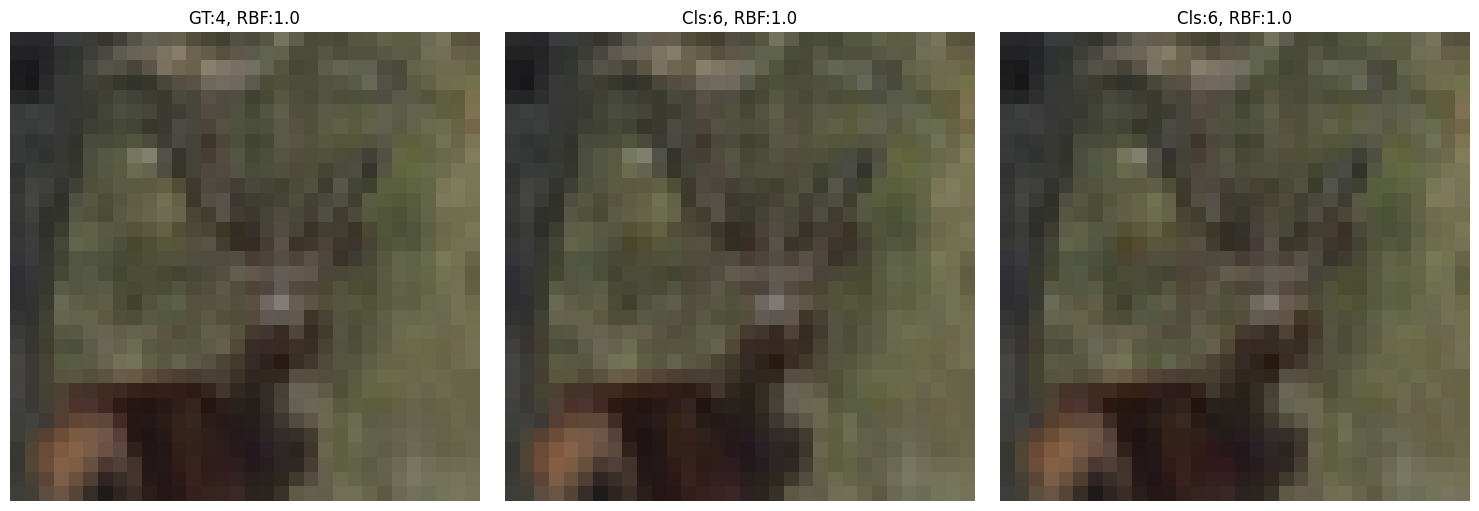

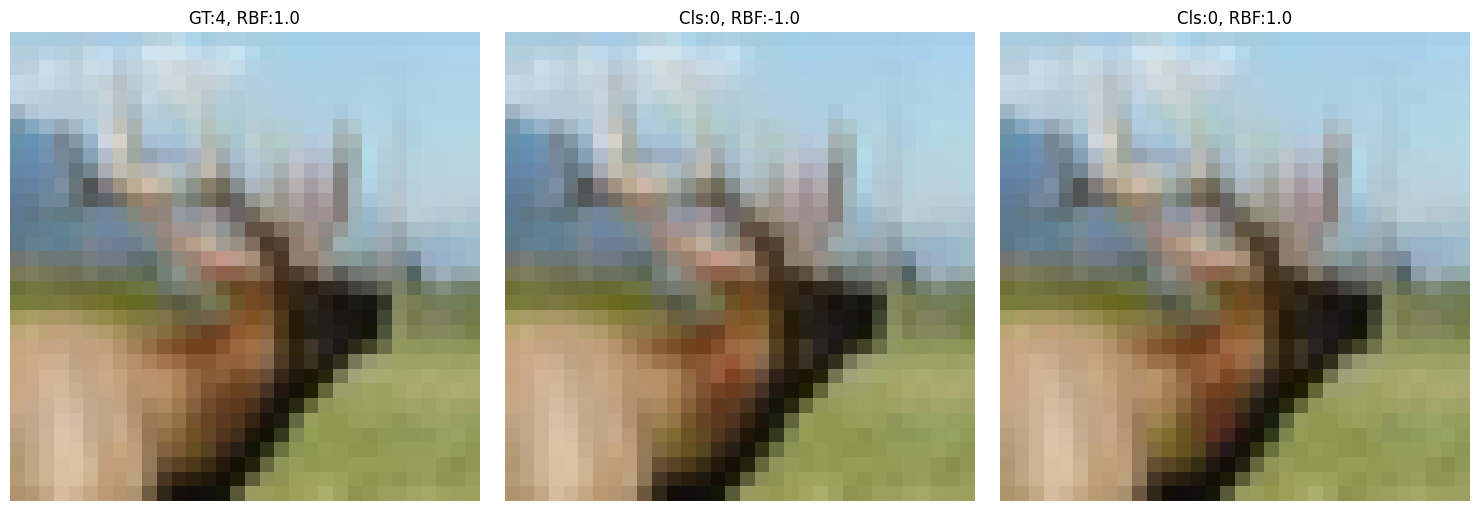

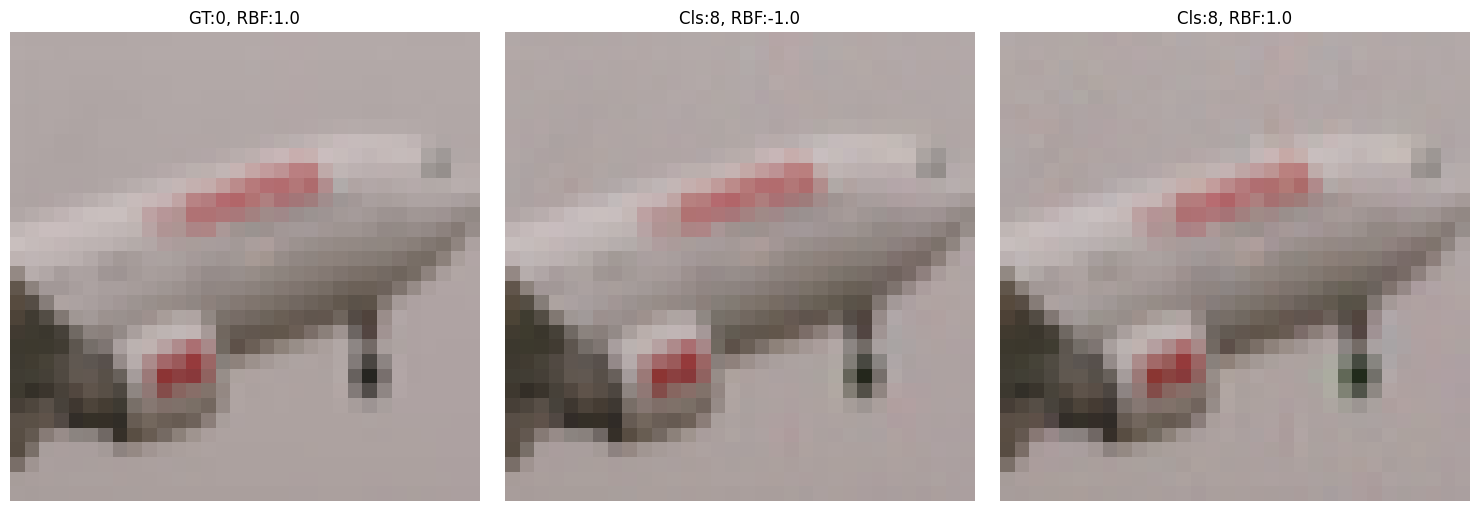

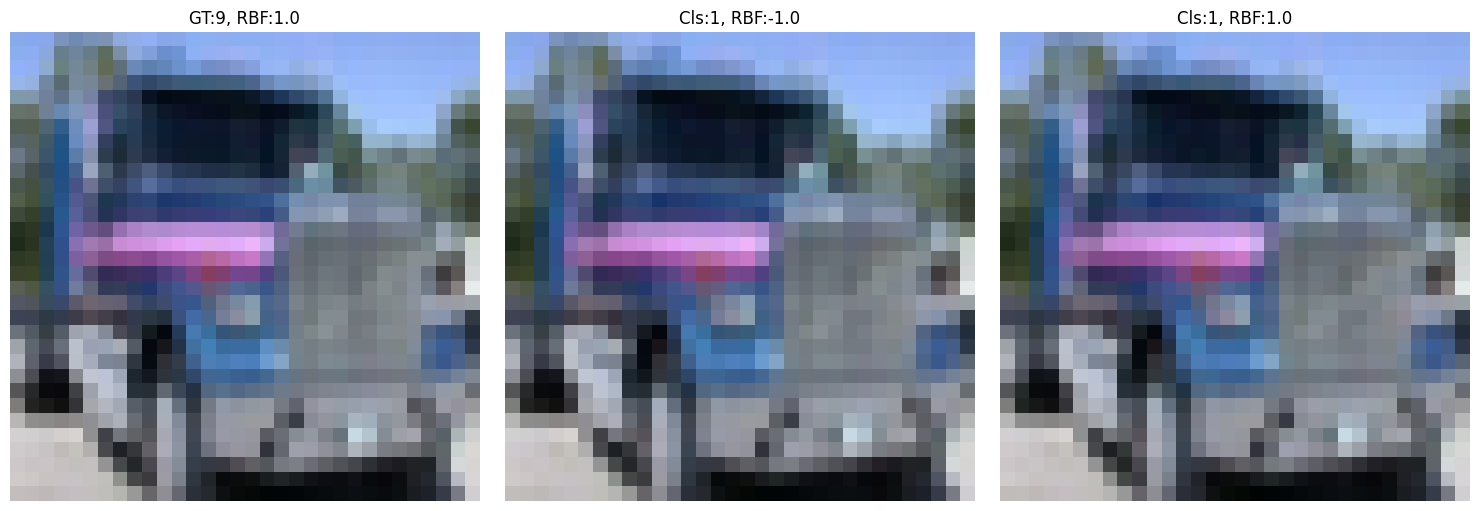

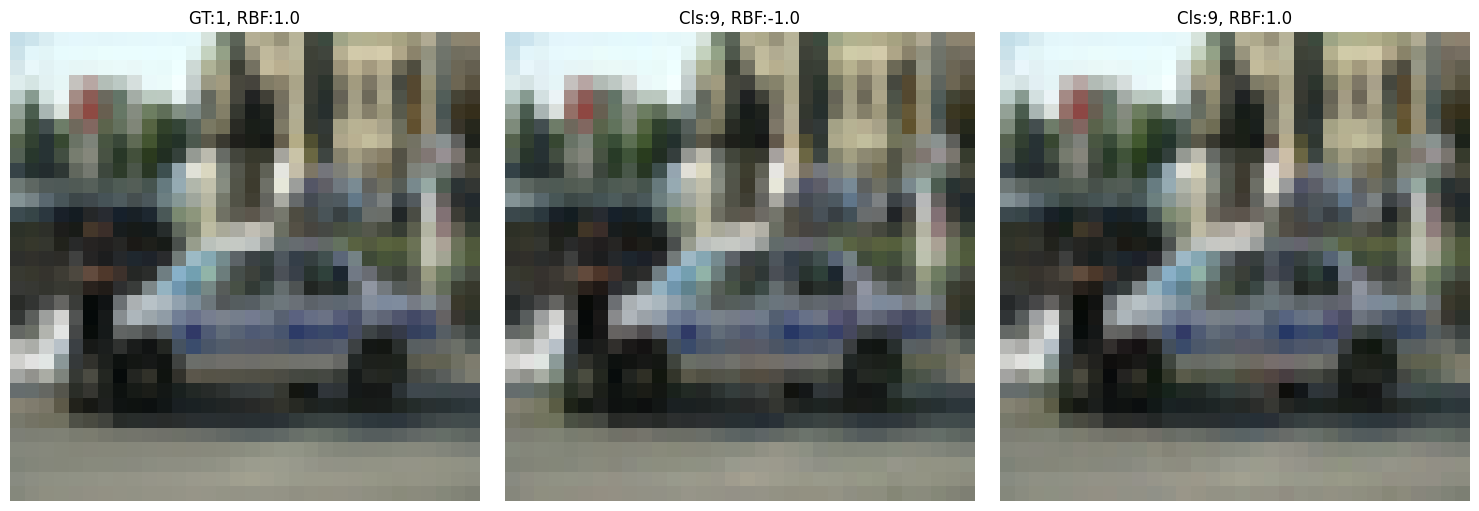

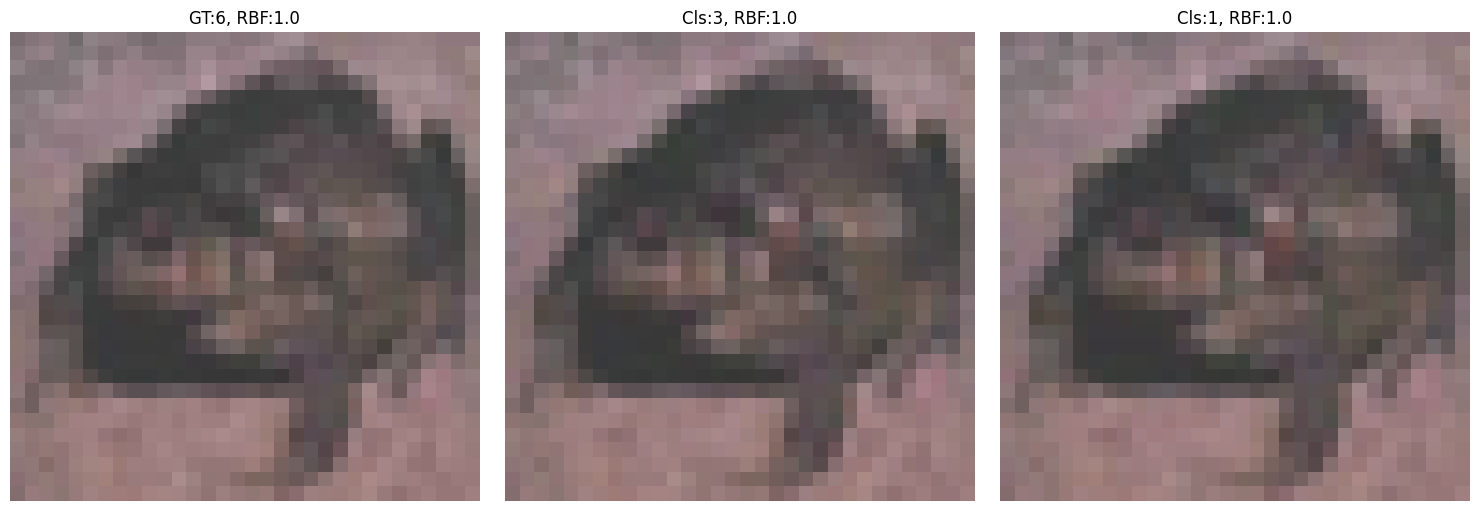

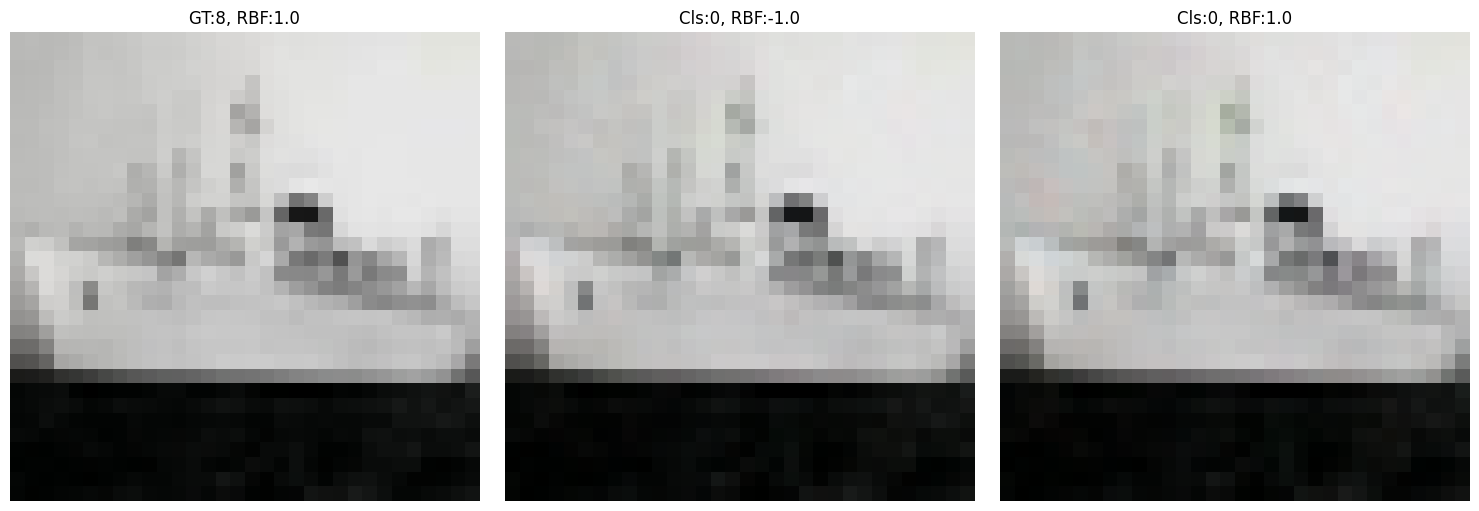

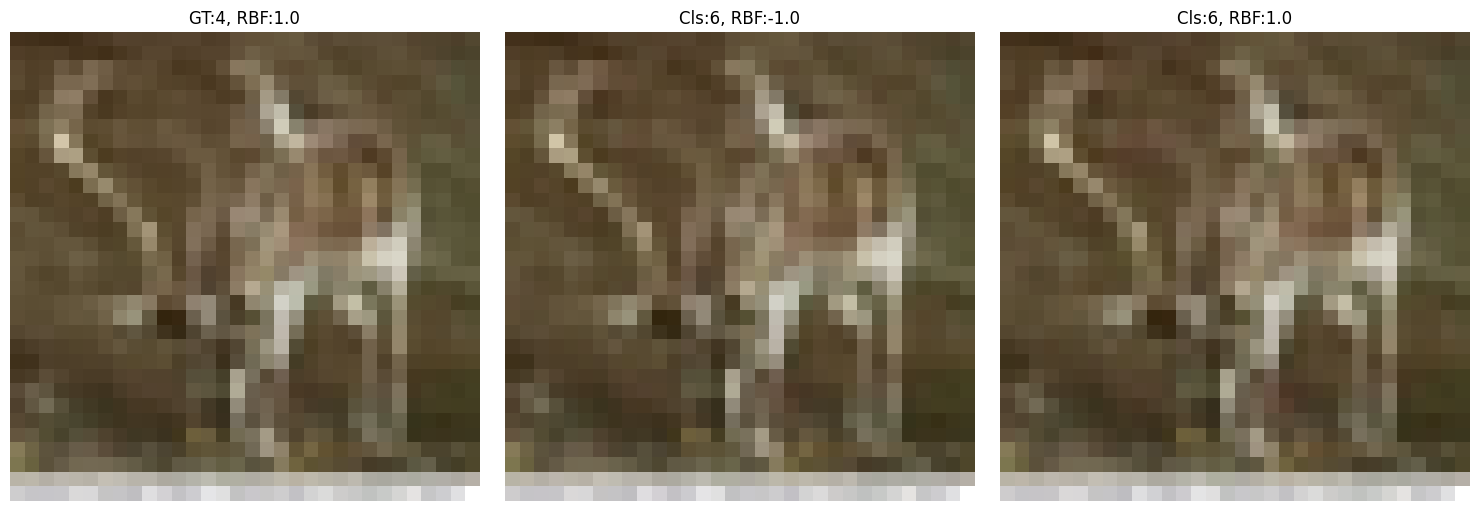

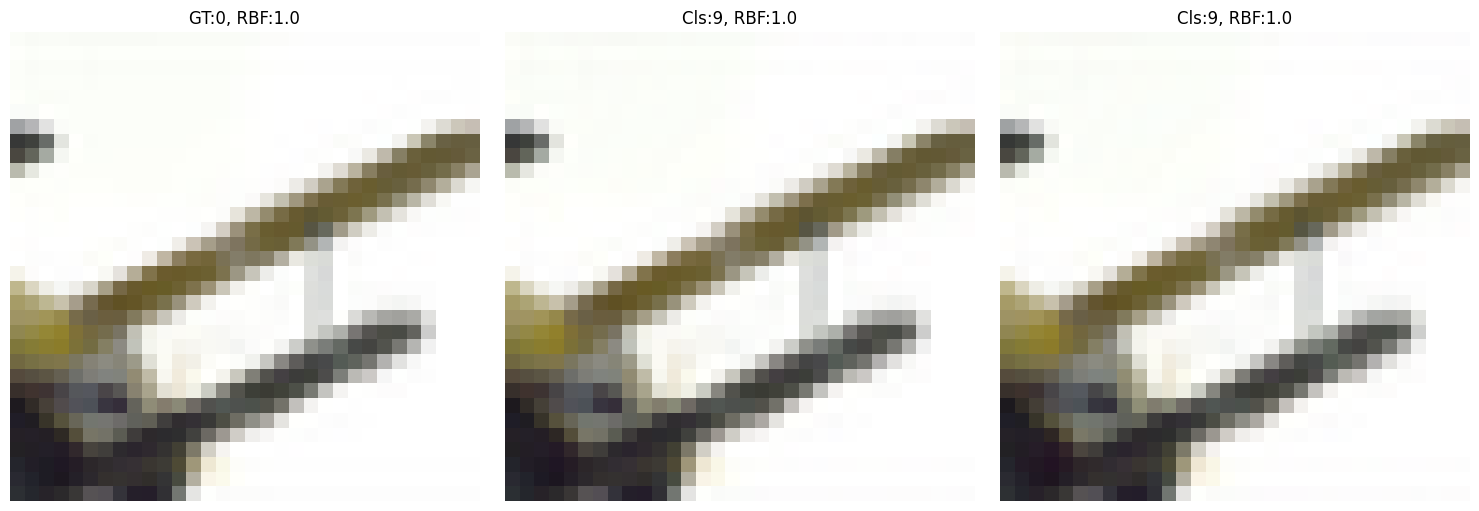

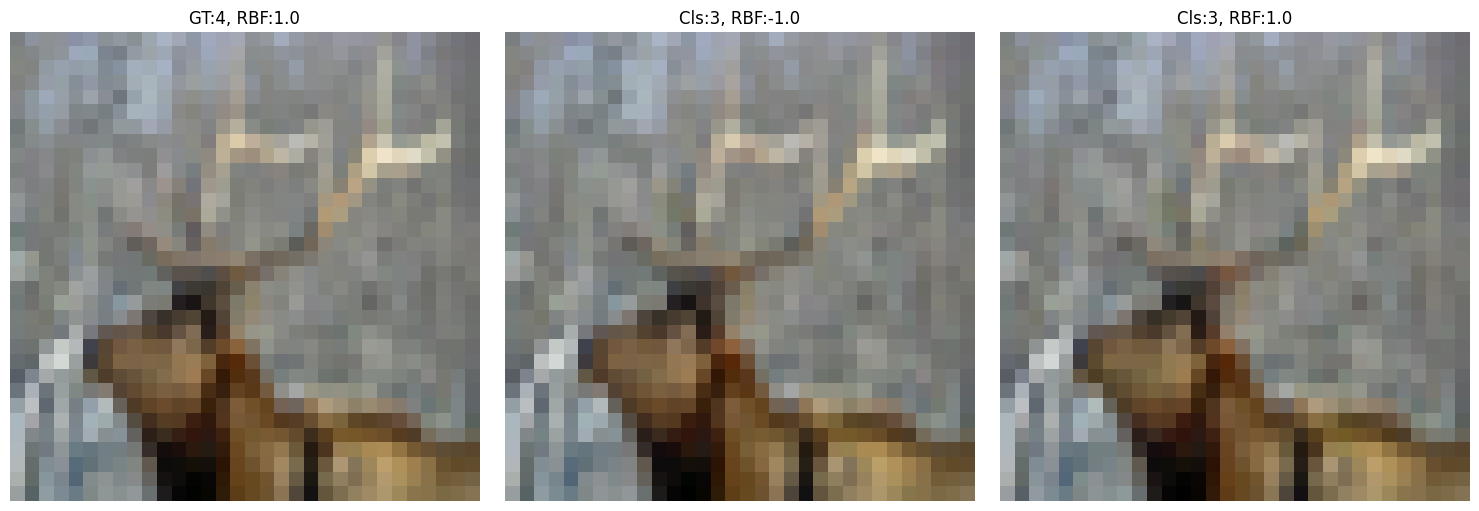

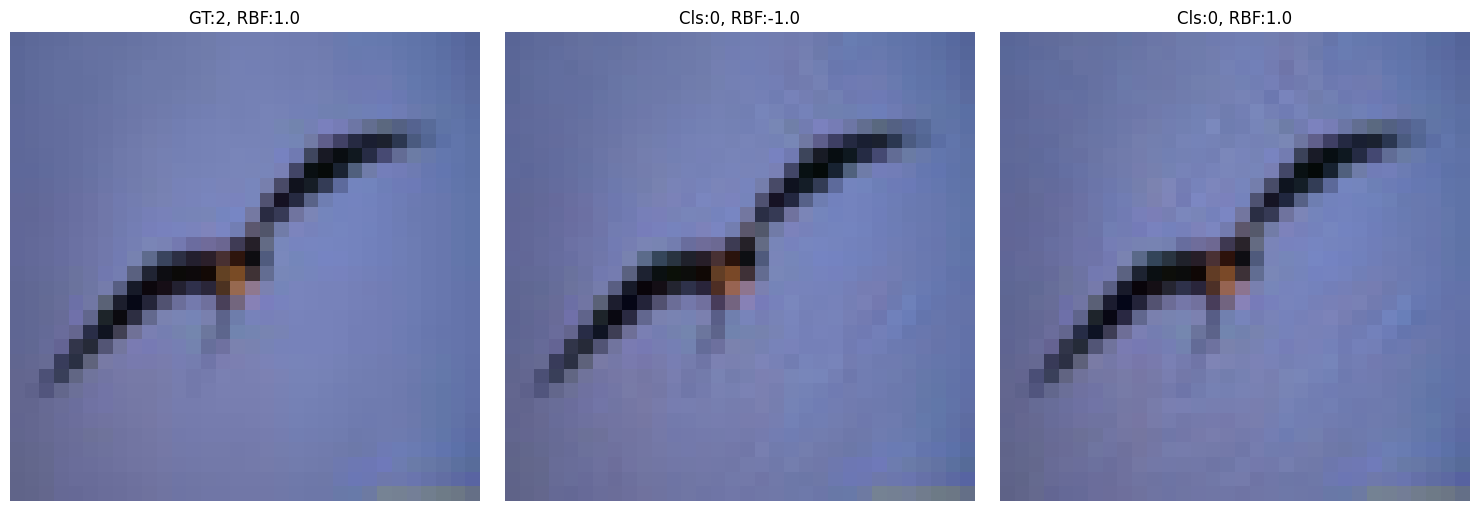

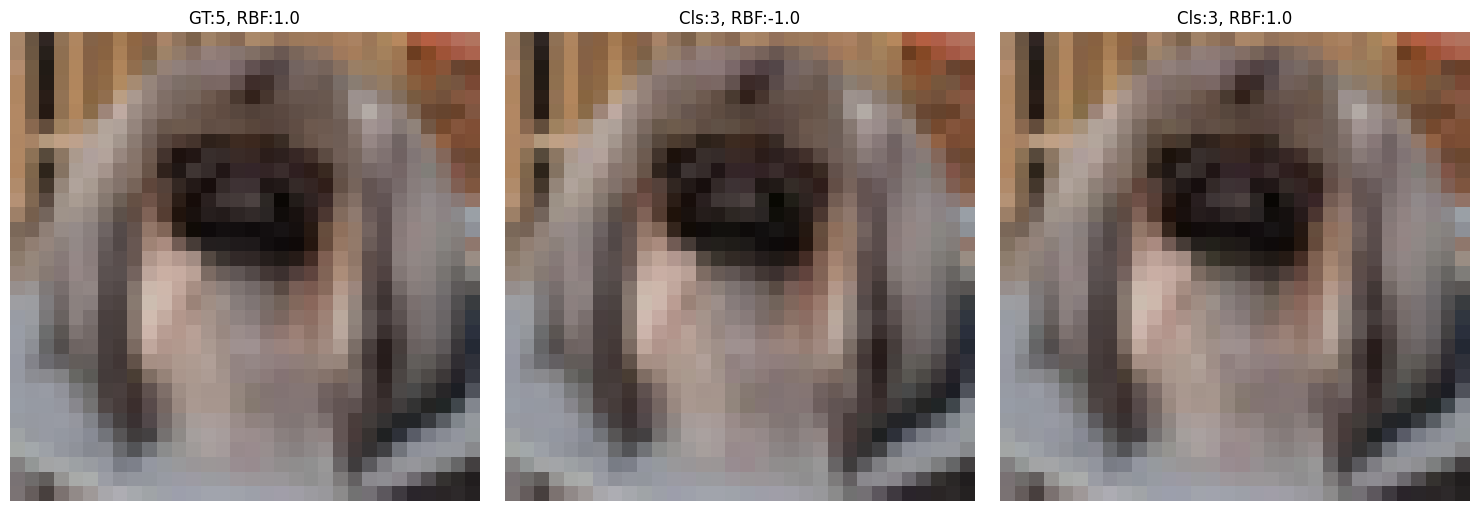

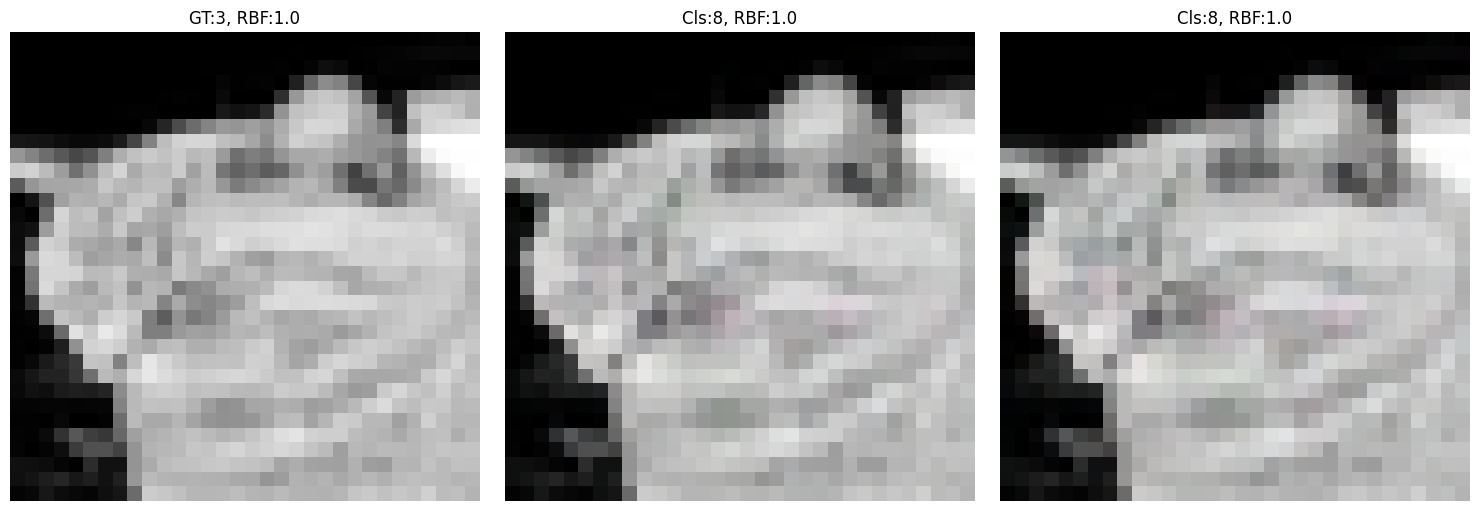

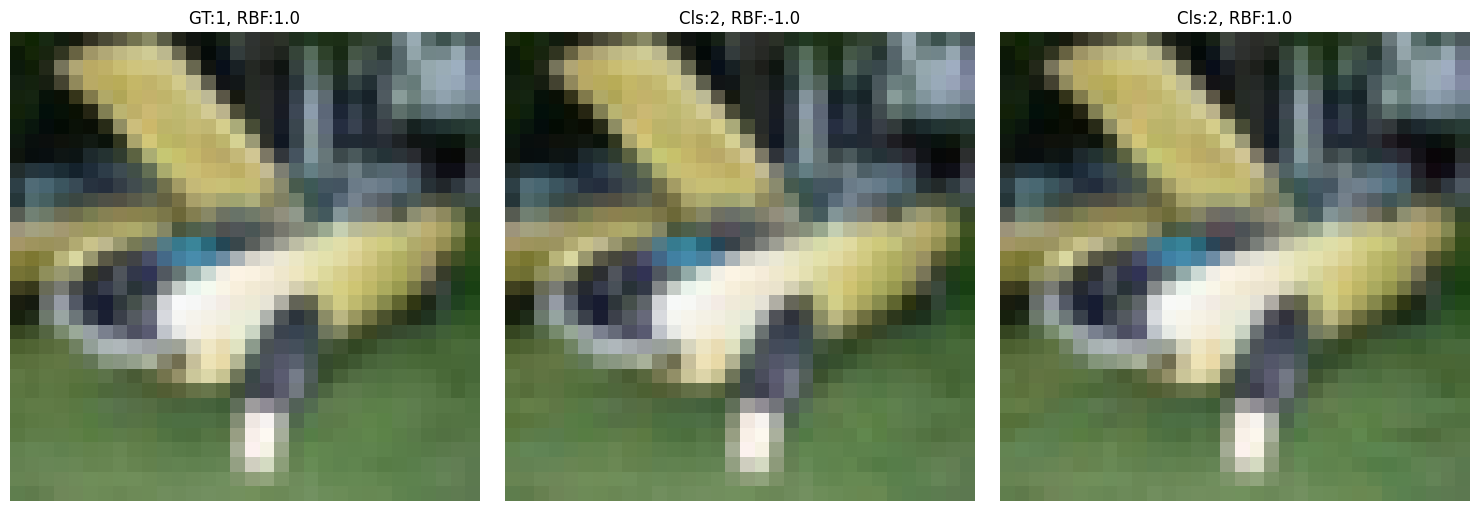

In [30]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Vis"

for idx in range(20):
    benign = images_benign[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
    title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base, title_integrated]
    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path, titles=titles)

In [ ]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Vis"

for idx in range(20):
    benign = images_benign_base[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
    title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base, title_integrated]
    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path, titles=titles)

# Quantized detector

In [69]:
detector = 'Quantized'
c_base=0.1
d_base=0.0
c_integrated=0.1
d_integrated=0.1

base_path = f"/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f"
images_cw_base = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"
images_cw_rbf = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
images_benign = f"Benign_Datasets/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{c_integrated}.pickle"

predictions_integrated = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
predictions_base = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"

predictions_benign_rbf = f"Predictions/RBF/CW_type-benign_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_base_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_integrated_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_rbf_c-{c_integrated}_d-{d_integrated}.pickle"

filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pt"
filtered_indices_integrated = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pt" 

images_cw_base = os.path.join(base_path, images_cw_base)
images_cw_rbf = os.path.join(base_path, images_cw_rbf)
images_benign = os.path.join(base_path, images_benign)
predictions_base_path = os.path.join(base_path, predictions_base)
predictions_integrated_path = os.path.join(base_path, predictions_integrated)

predictions_benign_rbf_path = os.path.join(base_path, predictions_benign_rbf)
predictions_base_rbf_path = os.path.join(base_path, predictions_base_rbf)
predictions_integrated_rbf_path = os.path.join(base_path, predictions_integrated_rbf)


filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)
filtered_indices_integrated_path = os.path.join(base_path, filtered_indices_integrated)




In [70]:
# Filter by common indices
filtered_indices_base = torch.load(filtered_indices_base_path)
filtered_indices_integrated = torch.load(filtered_indices_integrated_path)


filtered_indices_base = [x.item() for x in filtered_indices_base]
filtered_indices_integrated = [x.item() for x in filtered_indices_integrated]
base_indices = set(filtered_indices_base)
integrated_indices = set(filtered_indices_integrated)
common_indices = list(base_indices.intersection(integrated_indices))


with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)
    images_cw_base[0] = images_cw_base[0][common_indices]
    images_cw_base[1] = images_cw_base[1][common_indices]
    

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)
    images_cw_rbf[0] = images_cw_rbf[0][common_indices]
    images_cw_rbf[1] = images_cw_rbf[1][common_indices]


with open(images_benign, 'rb') as in_file:
    images_benign = pickle.load(in_file)
    images_benign[0] = images_benign[0][common_indices]
    images_benign[1] = images_benign[1][common_indices]

with open(predictions_base_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_integrated_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_benign_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_benign_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_base_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_integrated_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])[common_indices]





In [71]:
idx = 78


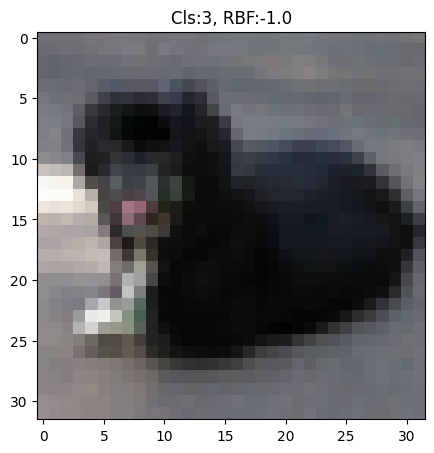

In [34]:
title = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
imshow(images_cw_base[0][idx], title=title)

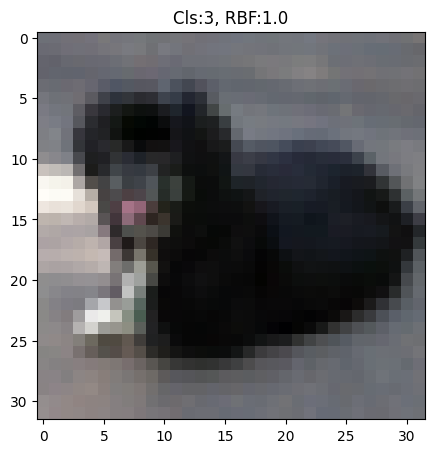

In [35]:
title = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
imshow(images_cw_rbf[0][idx], title=title)

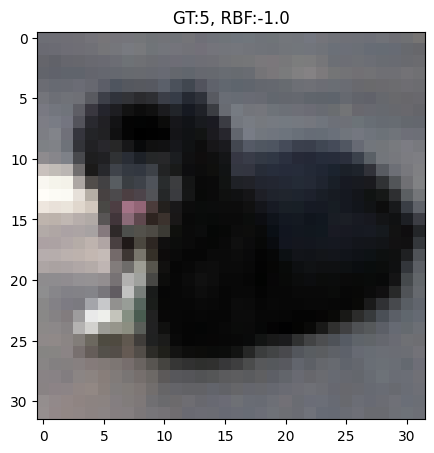

In [36]:
title = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
imshow(images_benign[0][idx], title=title)

# Compute pixel-wise metrics


In [76]:
MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [77]:
l2_loss_base_per_sample = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base_per_sample = l2_loss_base_per_sample.sum(dim=1).mean()

l2_loss_integrated_per_sample = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_integrated_per_sample = l2_loss_integrated_per_sample.sum(dim=1).mean()
print(f"L2 Ball : Base {l2_loss_base_per_sample}, Integrated : {l2_loss_integrated_per_sample}")

L2 Ball : Base 0.03261010721325874, Integrated : 0.07401936501264572


In [78]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
print(f"Mean Per pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Mean Per pixel : Base 1.0615271094138734e-05, Integrated : 2.4094846594380215e-05


In [79]:
l2_loss_base = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean().item()

l2_loss_rbf = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
l2_loss_rbf = l2_loss_rbf.mean().item()
#print("Mean max pixel differene between CW RBF and benign is : ", l2_loss_rbf.item())
#print("Mean max pixel differene between CW base and benign is : ", l2_loss_base.item())
print(f"Max pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Max pixel : Base 0.0004507950216066092, Integrated : 0.0004925986286252737


In [ ]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/VisQuantized"

for idx in range(20):
    benign = images_benign[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
    title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base, title_integrated]
    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path, titles=titles)